# Lab 2 Sample Code

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time


In [22]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z


def tanh(Z):
    A = np.tanh(Z)
    return A, Z


def relu(Z):
    A = np.maximum(0, Z)
    return A, Z


def leaky_relu(Z):
    A = np.maximum(0.1 * Z, Z)
    return A, Z

def sigmoid_gradient(dA, Z):
    A, Z = sigmoid(Z)
    dZ = dA * A * (1 - A)

    return dZ


def tanh_gradient(dA, Z):
    A, Z = tanh(Z)
    dZ = dA * (1 - np.square(A))

    return dZ


def relu_gradient(dA, Z):
    A, Z = relu(Z)
    dZ = np.multiply(dA, np.int64(A > 0))

    return dZ


class GenData:
    @staticmethod
    def _gen_linear(n=100):
        """Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, (x > y).astype(np.int64).reshape((-1, 1))

    @staticmethod
    def _gen_xor(n=100):
        """Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def _gen_chessboard(n=100):
        """Data generation (Chessboard)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        pos = np.array([(np.random.random(), np.random.random()) for i in range(n)])
        x, y = pos[:, 0], pos[:, 1]
        return pos, ((x < 0.25) ^ (x > 0.5) ^ (x > 0.75) ^ (y < 0.25) ^ (y > 0.5) ^ (y > 0.75)).astype(np.int64).reshape(
            (-1, 1)
        )

    @staticmethod
    def fetch_data(mode, n):
        """Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == "Linear" or mode == "XOR" or mode == "Chessboard"

        data_gen_func = {"Linear": GenData._gen_linear, "XOR": GenData._gen_xor, "Chessboard": GenData._gen_chessboard}[mode]

        return data_gen_func(n)


class SimpleNet:
    def __init__(self, num_step=6000, print_interval=100, learning_rate=1e-2):  # don't change print_interval
        """A hand-crafted implementation of simple network.

        Args:
            num_step (optional):    the total number of training steps.
            print_interval (optional):  the number of steps between each reported number.
        """
        self.num_step = num_step
        self.print_interval = print_interval
        self.learning_rate = learning_rate

        self.nn_architecture = [
            {"input_dim": 2, "output_dim": 100, "activation": "relu"},
            {"input_dim": 100, "output_dim": 50, "activation": "relu"},
            {"input_dim": 50, "output_dim": 10, "activation": "relu"},
            {"input_dim": 10, "output_dim": 1, "activation": "sigmoid"}
        ]

    @staticmethod
    def plot_result(data, gt_y, pred_y):
        """Data visualization with ground truth and predicted data comparison. There are two plots
        for them and each of them use different colors to differentiate the data with different labels.

        Args:
            data:   the input data
            gt_y:   ground truth to the data
            pred_y: predicted results to the data
        """
        assert data.shape[1] == gt_y.shape[1] == pred_y.shape[1], f"{data.shape}, {gt_y.shape}, {pred_y.shape}"

        plt.figure(figsize=(11, 5))

        plt.subplot(121)
        plt.title("Ground Truth", fontsize=18)
        plt.scatter(data[0,:], data[1,:], c=gt_y[0,:], cmap=plt.cm.bwr)

        plt.subplot(122)
        plt.title("Prediction", fontsize=18)
        plt.scatter(data[0,:], data[1,:], c=pred_y[0,:], cmap=plt.cm.bwr)

        plt.show()

    def initialize_parameters(self, nn_architecture):
        np.random.seed(1)
        parameters = {}
        # L = len(layers_dims)            

        for idx, layer in enumerate(nn_architecture):
        # for l in range(1, L):
            layer_idx = idx + 1
            parameters['wei' + str(layer_idx)] = np.random.randn(
                layer["output_dim"], layer["input_dim"]) * 0.1
            parameters['bias' + str(layer_idx)] = np.random.randn(
                layer["output_dim"], 1) * 0.1

            assert parameters["wei" + str(layer_idx)].shape == (
                layer["output_dim"], layer["input_dim"])
            assert parameters["bias" + str(layer_idx)].shape == (
                layer["output_dim"], 1)
        
        return parameters

    # Define helper functions that will be used in L-model forward prop
    def single_forward_propagation(self, A_prev, W, b, activation_fn):
        assert activation_fn == "sigmoid" or activation_fn == "tanh" or \
            activation_fn == "relu"

        if activation_fn == "sigmoid":
             activation = sigmoid

        elif activation_fn == "tanh":
             activation = tanh

        elif activation_fn == "relu":
             activation = relu

        Z = np.dot(W, A_prev) + b
        AprevWeiBias_cache = (A_prev, W, b)
        A, Z_cache = activation(Z)

        assert A.shape == (W.shape[0], A_prev.shape[1])

        cache = (AprevWeiBias_cache, Z_cache)

        return A, cache

    def forward(self, input, parameters, nn_architecture):
        A = input
        caches = []                       

        for index, layer in enumerate(nn_architecture):
            layer_idx = index + 1
            A_prev = A
            A, cache = self.single_forward_propagation(
                A_prev, parameters["wei"+str(layer_idx)], parameters["bias"+str(layer_idx)], layer["activation"])
            caches.append(cache)

        assert A.shape == (1, input.shape[1])
        return A, caches

    # define helper functions that will be used in L-model back-prop
    def linear_backword(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dwei = (1 / m) * np.dot(dZ, A_prev.T)
        dbias = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)

        assert dA_prev.shape == A_prev.shape
        assert dwei.shape == W.shape
        assert dbias.shape == b.shape

        return dA_prev, dwei, dbias


    def single_backward_propagation(self, dA, cache, activation_fn):
        ApreWeiBias_cache, Z_cache = cache

        if activation_fn == "sigmoid":
            activation_gra = sigmoid_gradient
        
        elif activation_fn == "tanh":
            activation_gra = tanh_gradient
    
        elif activation_fn == "relu":
            activation_gra = relu_gradient
                    
        dZ = activation_gra(dA, Z_cache)

        A_prev, W, b = ApreWeiBias_cache
        m = A_prev.shape[1]

        dwei = (1 / m) * np.dot(dZ, A_prev.T)
        dbias = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        
        assert dA_prev.shape == A_prev.shape
        assert dwei.shape == W.shape
        assert dbias.shape == b.shape

        return dA_prev, dwei, dbias


    def backward(self, predict, label, caches, nn_architecture, parameters):
        label = label.reshape(predict.shape)
        gradients = {}
        numerator = predict - label
        denominator = np.multiply(predict, 1 - predict)
        denominator = np.clip(denominator, 10**-7, None)
        dacti_prev = np.divide(numerator, denominator)

        for idx, layer in reversed(list(enumerate(nn_architecture))):
            layer_idx = idx + 1
            dacti_curr = dacti_prev
            dacti_prev, dwei, dbias = self.single_backward_propagation(dacti_curr, caches[idx], layer["activation"])
            gradients["dacti"+str(layer_idx)] = dacti_prev
            gradients["dwei"+str(layer_idx)] = dwei
            gradients["dbias"+str(layer_idx)] = dbias
        # update parameters
        self.update_parameters(parameters, gradients, self.learning_rate, self.nn_architecture)

        return

    # Compute cross-entropy cost
    def criterion(self, predict, label):
        m = label.shape[1]
        predict = np.clip(predict, 10**-7, 1 - 10**-7)
        cost = -1 / m * (np.dot(label, np.log(predict).T) + np.dot(1 - label, np.log(1 - predict).T))
        return np.squeeze(cost)

    def update_parameters(self, parameters, gradients, learning_rate, nn_architecture):
        for idx, layer in enumerate(nn_architecture):
            layer_idx = idx + 1
            parameters["wei" + str(layer_idx)] = parameters[
                "wei" + str(layer_idx)] - learning_rate * gradients["dwei" + str(layer_idx)]
            parameters["bias" + str(layer_idx)] = parameters[
                "bias" + str(layer_idx)] - learning_rate * gradients["dbias" + str(layer_idx)]
        return parameters

    def train(self, inputs, labels, batch_size=1):
        """The training routine that runs and update the model.

        Args:
            inputs: the training (and testing) data used in the model.
            labels: the ground truth of correspond to inputs data.
        """
        assert inputs.shape[1] == labels.shape[1]
        n = int(inputs.shape[1]/batch_size)

        # initialize parameters
        parameters = self.initialize_parameters(self.nn_architecture)

        # intialize cost list
        cost_list = []
        best_acc = 0.0
        best_model_wts = {}

        since = time.time()        
        # iterate over num_iterations
        for epoch in range(self.num_step):
            for idx in range(n):
                idx *= batch_size
                # iterate over L-layers to get the final output and the cache
                predict, caches = self.forward(inputs[:,idx : idx + batch_size], parameters, self.nn_architecture)

                # compute cost to plot it
                cost = self.criterion(predict, labels[:,idx : idx + batch_size])

                # iterate over L-layers backward to get gradients
                self.backward(predict, labels[:,idx : idx + batch_size], caches, self.nn_architecture, parameters)
            
            if epoch % self.print_interval == 0:
                accuracy = self.test(inputs, parameters, labels)
                print(f"Epochs {epoch}:\taccuracy: {accuracy:.2f}")
                
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_model_wts = parameters
            

            if epoch % 100 == 0:
                cost_list.append(cost)

        time_elapsed = time.time() - since
        # plot the cost curve
        plt.figure(figsize=(10, 6))
        plt.plot(cost_list)
        plt.xlabel("Iterations (per hundreds)")
        plt.ylabel("Loss")
        plt.title(f"Loss curve for the learning rate = {self.learning_rate}")
        print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best test Acc: {best_acc:4f}%')

        return best_model_wts, best_acc

    def test(self, inputs, parameters, labels):
        probs, caches = self.forward(inputs, parameters, self.nn_architecture)
        y = (probs >= 0.5) * 1
        accuracy = np.mean(y == labels) * 100

        return accuracy

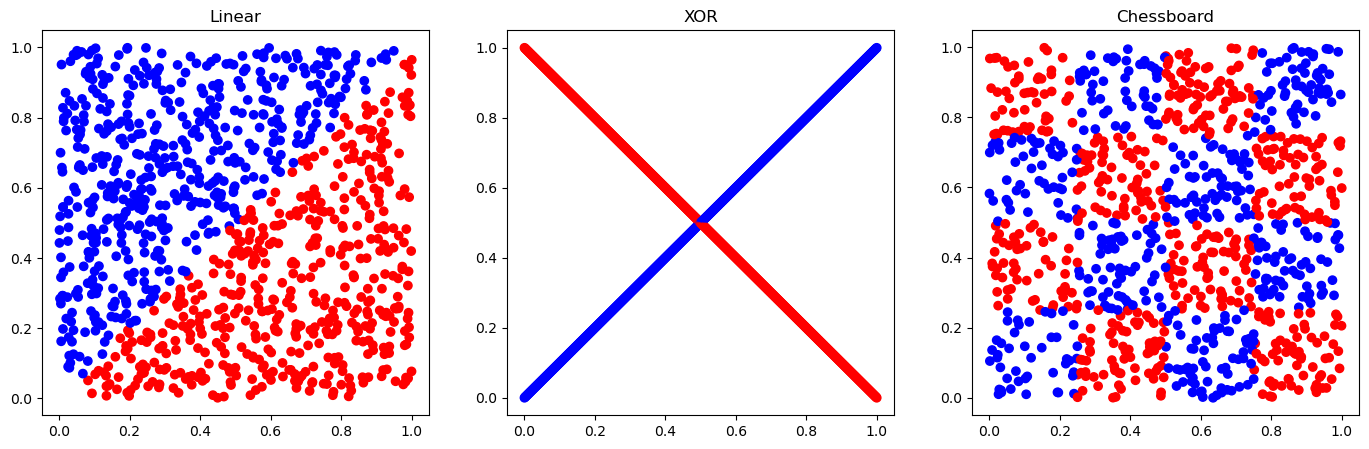

In [23]:
plt.figure(figsize=(17, 5))
for i, name in enumerate(['Linear', 'XOR', 'Chessboard']):
    data, label = GenData.fetch_data(name, 1000)
    plt.subplot(1,3,i+1)
    plt.scatter(data[:, 0], data[:, 1], c=label[:, 0], cmap=plt.cm.bwr)
    plt.title(name)

### Run "Linear"

Original dimensions:
--------------------
Training: (500, 2), (500, 1)

New dimensions:
---------------
Training: (2, 500), (1, 500)
Epochs 0:	accuracy: 50.60
Epochs 100:	accuracy: 50.60
Epochs 200:	accuracy: 88.40
Epochs 300:	accuracy: 91.80
Epochs 400:	accuracy: 91.20
Epochs 500:	accuracy: 97.60
Epochs 600:	accuracy: 100.00
Epochs 700:	accuracy: 100.00
Epochs 800:	accuracy: 100.00
Epochs 900:	accuracy: 100.00
Epochs 1000:	accuracy: 100.00
Epochs 1100:	accuracy: 100.00
Epochs 1200:	accuracy: 100.00
Epochs 1300:	accuracy: 100.00
Epochs 1400:	accuracy: 100.00
Epochs 1500:	accuracy: 100.00
Epochs 1600:	accuracy: 100.00
Epochs 1700:	accuracy: 100.00
Epochs 1800:	accuracy: 100.00
Epochs 1900:	accuracy: 100.00

Training complete in 0m 7s
Best test Acc: 100.000000%


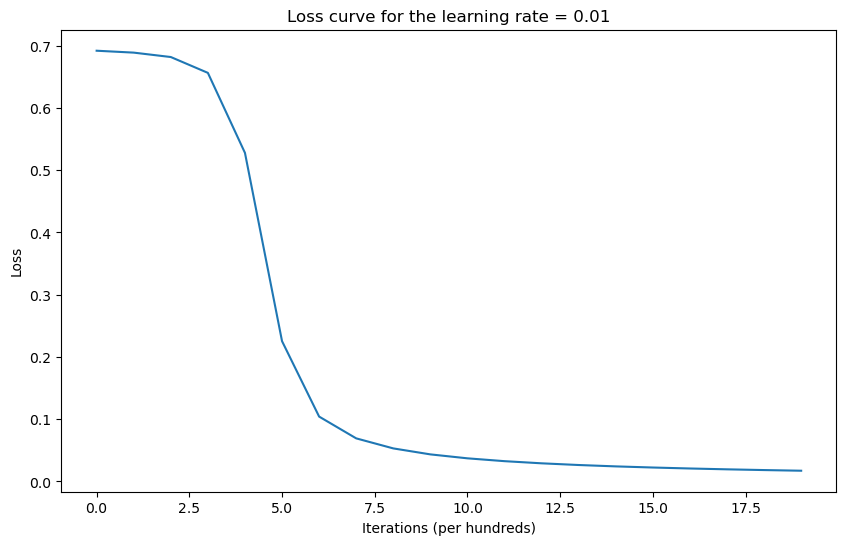

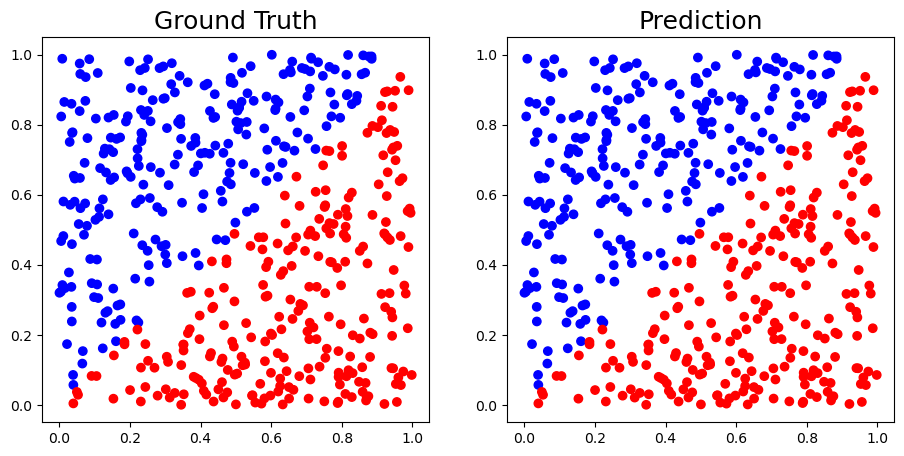

In [24]:
""" Customize your own code if needed """

data, label = GenData.fetch_data("Linear", 500)

print(f"Original dimensions:\n{20 * '-'}\nTraining: {data.shape}, {label.shape}")

data = data.T
label = label.reshape(-1, 500)
print(f"\nNew dimensions:\n{15 * '-'}\nTraining: {data.shape}, {label.shape}")

net = SimpleNet(2000)

parameters,_ = net.train(data, label, batch_size=100)

pred_result = np.round(net.forward(data, parameters, net.nn_architecture)[0])
SimpleNet.plot_result(data, label, pred_result)

### Run "XOR"

Original dimensions:
--------------------
Training: (500, 2), (500, 1)

New dimensions:
---------------
Training: (2, 500), (1, 500)
Epochs 0:	accuracy: 50.00
Epochs 100:	accuracy: 99.60
Epochs 200:	accuracy: 99.40
Epochs 300:	accuracy: 96.80
Epochs 400:	accuracy: 98.00
Epochs 500:	accuracy: 98.80
Epochs 600:	accuracy: 99.40
Epochs 700:	accuracy: 100.00
Epochs 800:	accuracy: 97.60
Epochs 900:	accuracy: 99.80
Epochs 1000:	accuracy: 98.40
Epochs 1100:	accuracy: 98.20
Epochs 1200:	accuracy: 97.60
Epochs 1300:	accuracy: 98.80
Epochs 1400:	accuracy: 99.00
Epochs 1500:	accuracy: 98.60
Epochs 1600:	accuracy: 99.20
Epochs 1700:	accuracy: 99.60
Epochs 1800:	accuracy: 98.60
Epochs 1900:	accuracy: 98.60

Training complete in 0m 7s
Best test Acc: 100.000000%


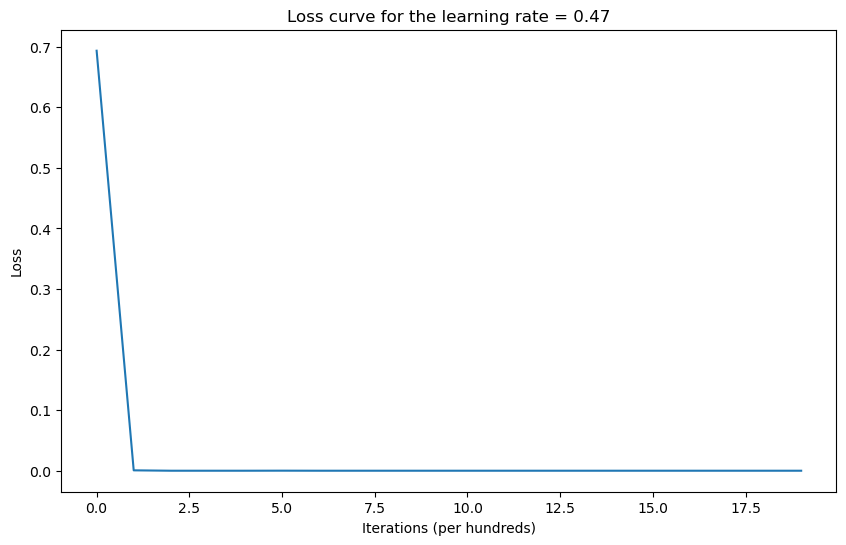

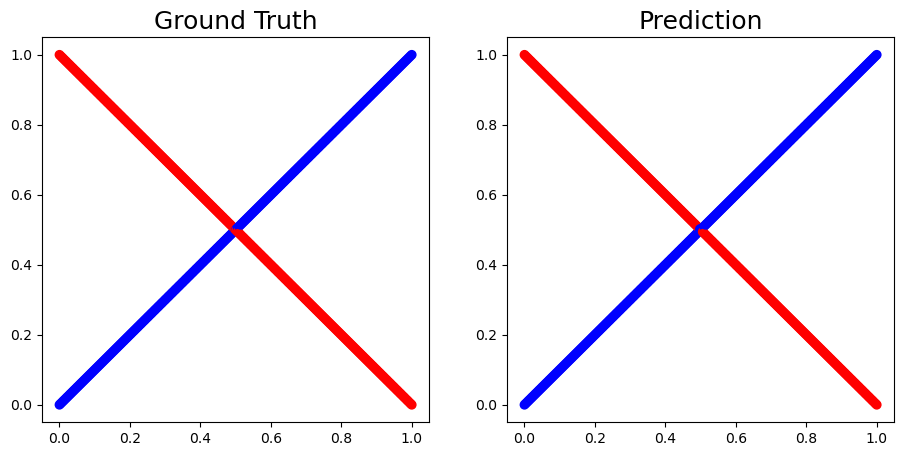

In [29]:
# best_lr = 0.0
# best_acc = 0.0
# log = []
# for i in range(60):
#     clear_output(wait=True)
#     lr = 0.6-0.01*i
#     print("current lr: ", lr)
#     print(f"current best acc: {best_acc:.2f}\tAt lr: {best_lr:.4f}")
""" Customize your own code if needed """

data, label = GenData.fetch_data("XOR", 500)

print(f"Original dimensions:\n{20 * '-'}\nTraining: {data.shape}, {label.shape}")

data = data.T
label = label.reshape(-1, 500)
print(f"\nNew dimensions:\n{15 * '-'}\nTraining: {data.shape}, {label.shape}")

net = SimpleNet(2000, learning_rate=0.47)

parameters, acc = net.train(data, label, batch_size=100)

pred_result = np.round(net.forward(data, parameters, net.nn_architecture)[0])
SimpleNet.plot_result(data, label, pred_result)

#     if acc > best_acc or acc == 100:
#         best_acc = acc
#         best_lr = lr
#         log.append({"lr": lr, "acc": acc})
#     time.sleep(1)

# print("best lr: ", best_lr)
# print("best acc: ", best_acc)
# print(log)


### Run "Chessboard"

In [ ]:
# from IPython.display import clear_output
# import time
    
# best_lr = 0.0
# best_acc = 0.0
# for i in range(900):
#     clear_output(wait=True)
#     lr = 0.9-0.001*i
#     print("lr: ", lr)
#     print(f"current best acc: {best_acc:.2f}\tAt lr: {best_lr:.4f}")
""" Customize your own code if needed """

data, label = GenData.fetch_data("Chessboard", 1000)


print(f"Original dimensions:\n{20 * '-'}\nTraining: {data.shape}, {label.shape}")

data = data.T
label = label.reshape(-1, 1000)
print(f"\nNew dimensions:\n{15 * '-'}\nTraining: {data.shape}, {label.shape}")

net = SimpleNet(2000, learning_rate=0.154)

parameters,acc = net.train(data, label, batch_size=100)

pred_result = np.round(net.forward(data, parameters, net.nn_architecture)[0])
SimpleNet.plot_result(data, label, pred_result)

#     if acc > best_acc:
#         best_acc = acc
#         best_lr = lr
#     time.sleep(1)

# print("best lr: ", best_lr)
# print("best acc: ", best_acc)

Original dimensions:
--------------------
Training: (1000, 2), (1000, 1)

New dimensions:
---------------
Training: (2, 1000), (1, 1000)


TypeError: train() got an unexpected keyword argument 'batch_size'